# Introduction et problématisation

# Aperçu de la base de données et nettoyage
  ## Installation de tous les packages nécessaires au projet

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np

In [160]:
!git clone -l -s git://https://github.com/marie-ganon/Projet-Python-S1.git
%cd cloned-repo
!ls

Cloning into 'Projet-Python-S1'...
fatal: unable to look up https (port 9418) (nodename nor servname provided, or not known)
[Errno 2] No such file or directory: 'cloned-repo'
/Users/h2jw/Desktop/GitHub/Projet-Python-S1
Notebook Projet GANON-HE.ipynb base_keywords.csv
README.md                      movies_metadata.csv.zip
base_clean.csv                 temp_dir


## Aperçu de la base initiale

La base que nous avons décidé de choisir pour mener à bien notre projet est un ensemble de données collecté par TMDB (The Movie Database, une API), ainsi que GroupLens, un laboratoire de recherche de l'université du Minnesota.

Le dataset est disponible à l'adresse suivante : https://www.kaggle.com/rounakbanik/the-movies-dataset.

Ces données regroupent plus de 45 000 films et donnent de nombreuses caractéristiques, tels que le genre, le budget et le revenu généré par le film. Une partie de la base a été prénettoyée sur Excel et avec des méthodes Python simples. 

In [161]:
# On crée un dossier temporaire pour dézipper le csv
import tempfile

temp_dir = tempfile.mkdtemp()


In [162]:
# Pour dezipper le csv disponible dans le git (movies metadata)

import zipfile

with zipfile.ZipFile('movies_metadata.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')
    

In [198]:
df = pd.read_csv(r'temp_dir/movies_metadata.csv', sep=',', low_memory = False)

On regarde tout d'abord si la base comporte beaucoup de cellules vides :

Complétude totale en pourcentage de la base : 90.32592120119062 %


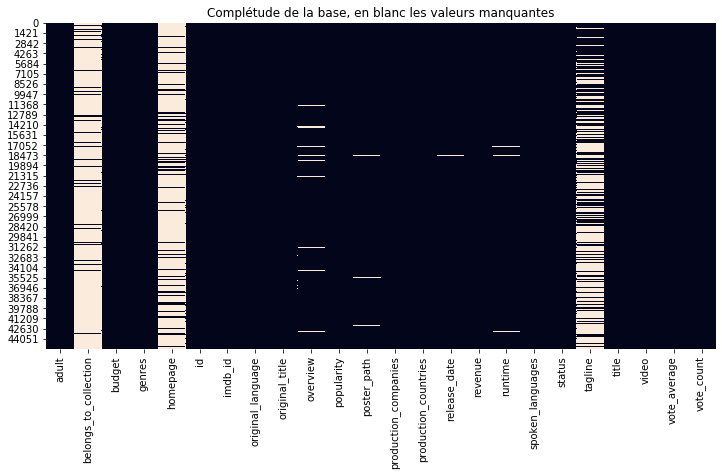

In [164]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')
print("Complétude totale en pourcentage de la base :", (1-df.isnull().sum().sum()/(len(df.id)*len(df.columns)))*100,'%')

## Détails des colonnes de la base

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Nettoyage de la base

## Suppression des colonnes non-utilisées

Notre base de données est très volumineuse. Or toutes les colonnes ne nous seront pas utiles pour notre analyse. Par conséquent, pour une question de mémoire nous avons décidé de les supprimer. 

En particulier, les informations données dans la colonne *spoken_languages* étant peu claires, nous préférons enlever cette colonne de notre dataset.

In [199]:
df = df.drop(columns ='spoken_languages')

## Nettoyage de *production_companies* 

In [167]:
df.production_companies

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45466, dtype: object

Dans la cellule de code suivante, nous allons récupérer les noms des companies de production, ainsi que leur identifiant. Celui-ci s'avérera utile par la suite.

In [200]:
df_temp = df.production_companies.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['name'] = df_temp.str.get(0)
df_1['id'] = df_temp.str.get(1)
df['production_companies_name'] = df_1.name.str.split(':').str.get(1)
df_2['production_companies_id'] = df_1.id.str.split(':').str.get(1)


In [169]:
import re
l = []
for elem in df_2['production_companies_id']:
  string1 = str(elem)
  l.append(map(int, re.findall(r'\d+', string1)))
df['production_companies_id']= pd.DataFrame(l)


In [170]:
df.production_companies_name

0                        'Pixar Animation Studios'
1                               'TriStar Pictures'
2                                   'Warner Bros.'
3         'Twentieth Century Fox Film Corporation'
4                          'Sandollar Productions'
                           ...                    
45461                                          NaN
45462                                'Sine Olivia'
45463                    'American World Pictures'
45464                                  'Yermoliev'
45465                                          NaN
Name: production_companies_name, Length: 45466, dtype: object

On retire ensuite les guillemets qui se trouvent dans les cellules de cette colonne.

In [171]:
df.production_companies_name = df.production_companies_name.str.replace(r'[^\w\s]+', '')
#df.production_companies_id= df.production_companies_id.str.replace(r'[^\w\s]+', '')

Text(0.5, 1.0, 'Occurrences des 500 premières entreprises de production')

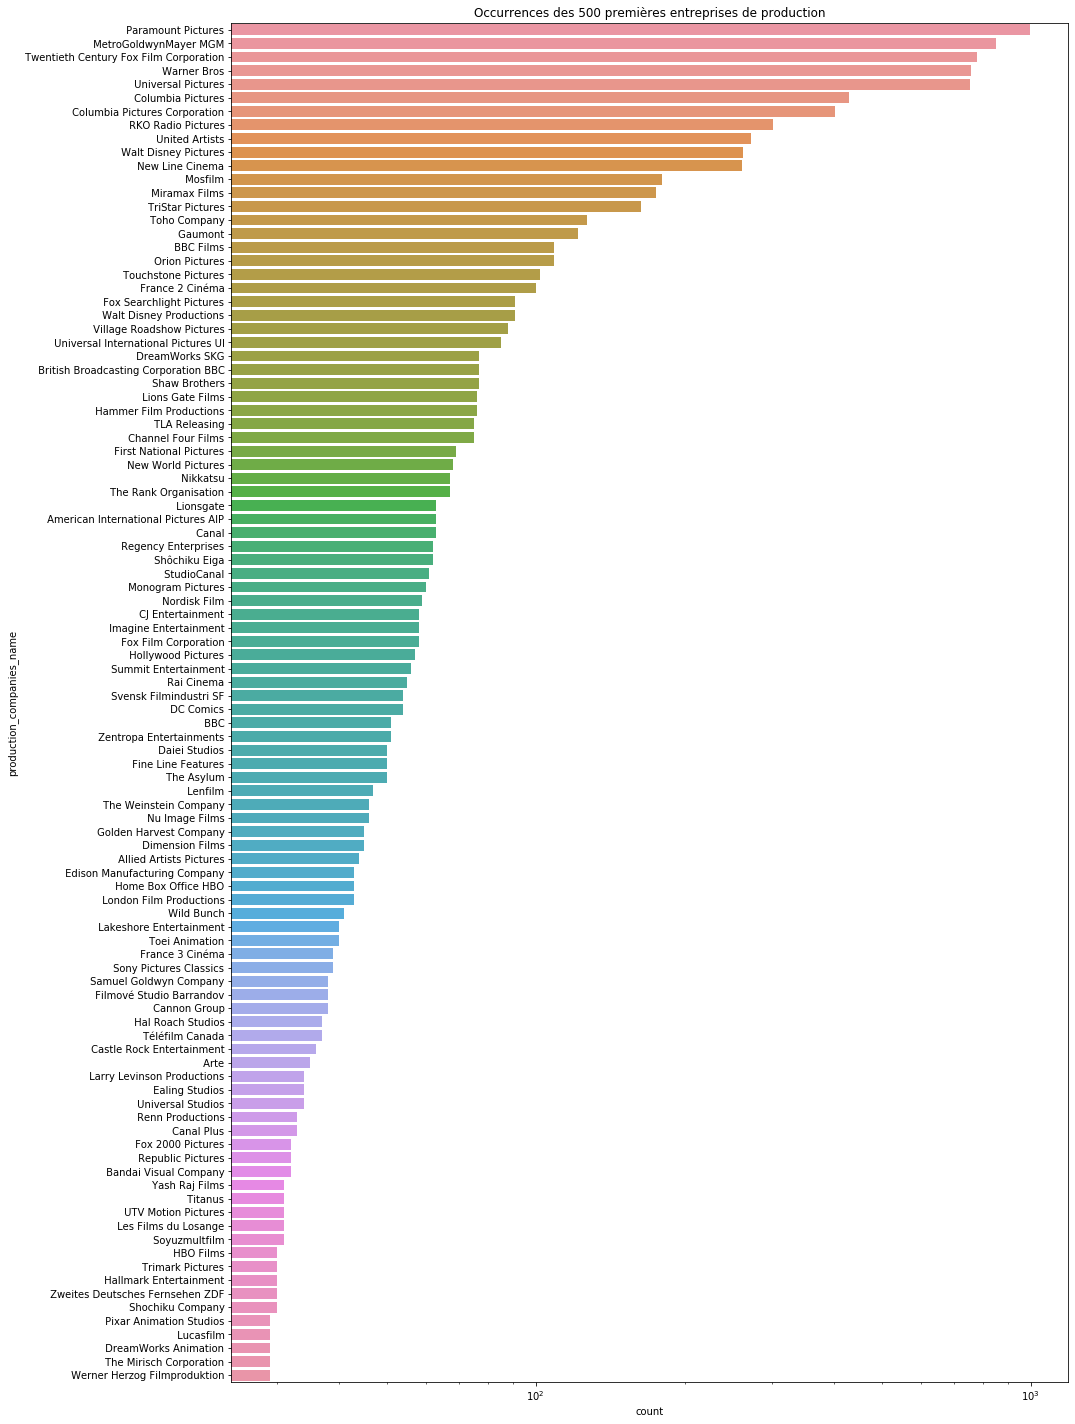

In [172]:
fig, ax = plt.subplots(figsize=(15,25))
sns.countplot(y = df.production_companies_name, data = df, order =df.production_companies_name.value_counts().iloc[:100].index)
ax.set_xscale('log')
plt.title('Occurrences des 500 premières entreprises de production')

Nous pouvons remarquer quelques effets à corriger : certains films sont mal regroupés en raison de l'utilisation des acronymes ou du nom complet de la société de production. Par exemple, Lionsgate  est également présent sous le nom Lions Gate, de même avec la BBC et British Broadcasting Channel etc. 

Une façon de contourner ce problème est de lier les noms aux id. 

In [173]:
df.production_companies_id.describe()

count    33402.000000
mean     10582.189540
std      18087.974359
min          1.000000
25%        512.000000
50%       3929.500000
75%      10285.000000
max      96067.000000
Name: production_companies_id, dtype: float64

Text(0.5, 1.0, 'Occurrences des 500 premières entreprises de production')

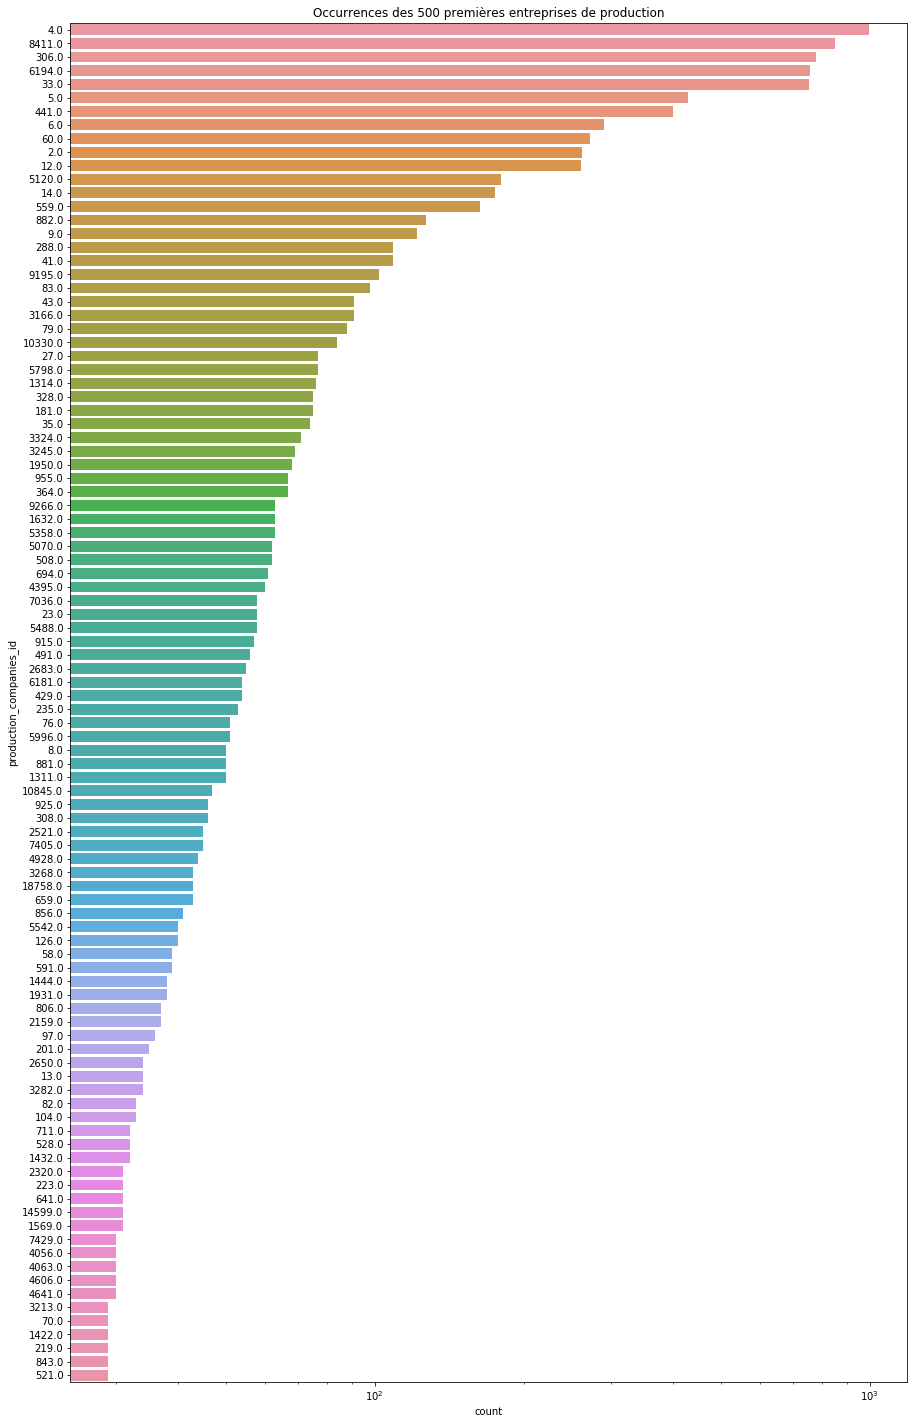

In [174]:
fig, ax = plt.subplots(figsize=(15,25))
sns.countplot(y = df.production_companies_id, data = df, order =df.production_companies_id.value_counts().iloc[:100].index)
ax.set_xscale('log')
plt.title('Occurrences des 500 premières entreprises de production')

## Nettoyage de *production_countries*

Là encore, grâce à la fonction split(), nous pouvons conserver uniquement ce qui nous intéresse, ici le pays de production du film.

In [175]:
df.production_countries.str.split(',').str.get(1)

0         'name': 'United States of America'}]
1         'name': 'United States of America'}]
2         'name': 'United States of America'}]
3         'name': 'United States of America'}]
4         'name': 'United States of America'}]
                         ...                  
45461                         'name': 'Iran'}]
45462                  'name': 'Philippines'}]
45463     'name': 'United States of America'}]
45464                       'name': 'Russia'}]
45465               'name': 'United Kingdom'}]
Name: production_countries, Length: 45466, dtype: object

In [176]:
df_temp = df.production_countries.str.split(',')
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['country_code'] = df_temp.str.get(0)
df_1['country_name'] = df_temp.str.get(1)
df['country_code'] = df_1.country_code.str.split(':').str.get(1)
df_2['country_name_try'] = df_1.country_name.str.split(':').str.get(1)
df['country_name']=df_2['country_name_try'].str.split('}').str.get(0)

df.country_code = df.country_code.str.replace(r'[^\w\s]+', '')
df.country_name = df.country_name.str.replace(r'[^\w\s]+', '')

On supprime alors les colonnes dédoublées lors du nettoyage. 

In [177]:
df = df.drop(columns=['production_companies','production_countries'])

Text(0.5, 1.0, 'Occurrences totales des pays de production')

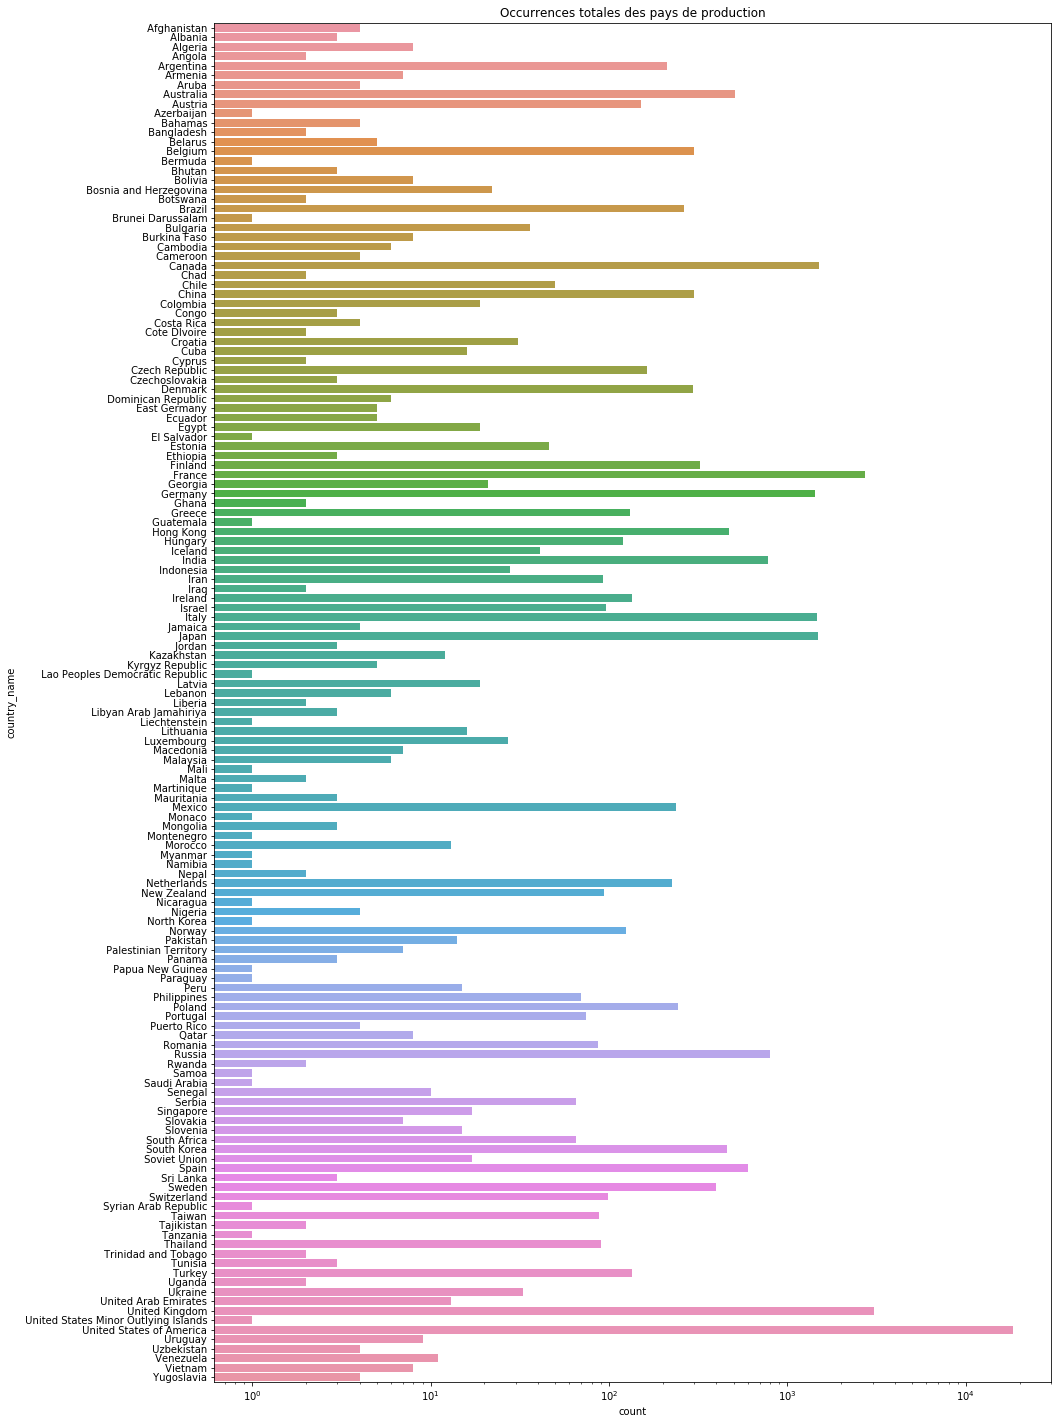

In [178]:
fig, ax = plt.subplots(figsize=(15,25))
sns.countplot(y = df.country_name.sort_values())
ax.set_xscale('log')
plt.title('Occurrences totales des pays de production')

La variable *country_name* est suffisamment propre. Intéressons-nous à sa complétude.

Country_name est complet à  86.16988518893238 %


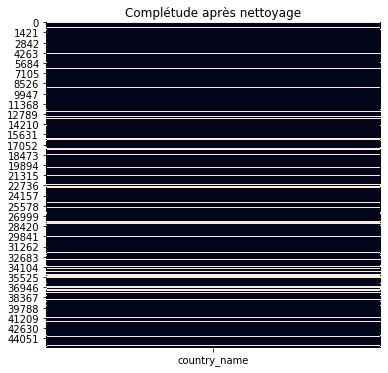

In [179]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[['country_name']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Country_name est complet à ',(1-len(df.country_name[df.country_name.isnull()])/len(df.country_name))*100,'%')

Nous remarquons que conserver certains mots dans les cellules de la base, tels que les 'id', 'name', ne sont pas pertinents. Par ailleurs, il sera plus lisible de pouvoir associer les identifiants de langue ISO_639-1 à leur langue dans la colonne *original_language*. Ces deux objectifs sont l'objet des sections suivantes.




## Nettoyage de la variable *original_language*

Dans notre base de données, les langues originales dans lequel le film est apparu sont codées de cette manière :

In [180]:
df.original_language[0]

'en'

En fait, il s'agit des identifiants ISO_639-1 de chaque langue (en l'occurence ici l'anglais). Pour plus de lisibilité, nous avons décidé de récupérer cette liste d'identifiants via une méthode de webscrapping, puis de créer une fonction qui renvoit la langue associée à son identifiant.

### Scraping de la liste ISO_639-1

La liste des codes IS0_639-1 est disponible sur l'url suivante : https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1.

Nous allons récupérer les identifiants, ainsi que les langues correspondantes:

In [24]:
url_iso = "https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1"
    
request_text = request.urlopen(url_iso).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Les informations que nous désirons étant contenues dans un tableau, on le récupère puis on le convertit en Data Frame.

In [25]:
table = page.find('table')
ls = str(table)
liste_iso = pd.DataFrame(pd.read_html(ls)[0])
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
182,yi,yid,yid + 2,Yiddish,ייִדיש,Yiddish,NaN
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN


Après une étude approfondie de la base, nous avons constaté que certains films possédaient l'identifiant 'cn' correspondant au cantonais. On le rajoute au Data Frame précédent: 

In [26]:
liste_iso.loc[187] = ['cn', 'NaN', 'NaN', 'Cantonais', 'NaN', 'Cantonese', 'NaN']
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN
186,zu,zul,zul,Zoulou,isiZulu,Zulu,NaN


### Nettoyage de la colonne

La fonction suivante permettra de récupérer la langue associée à un identifiant ISO_639-1. En la faisant tourner, nous nous sommes rendu compte que les NaN n'étaient pas toujours indiqués de la même manière. Il faut donc prendre en compte ces cas pour éviter toute erreur lors du lancement de la fonction.

In [181]:
def find_id(id):
  if id == '' or id == 'NaN' or id == 'xx' or id == 'nan' or id =='104.0' or id =='68.0' or id =='82.0':        # on élimine le cas où la langue n'est pas indiquée
    return ''
  i = 0
  while (str((liste_iso['639-1'])[i]) == id) == False and i<len(df):
    i += 1
  return liste_iso['Nom de la langue'][i]

On teste la fonction sur la première entrée de la colonne 'original_language'

In [28]:
test = str('en')
find_id(test)

'Anglais'

Puis on généralise la méthode à toutes les cellules de cette colonne :

In [29]:
for i in trange(len(df)):
  id = str(df.original_language[i])
  df.original_language[i] = find_id(id)

/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
df.original_language

0        Anglais
1        Anglais
2        Anglais
3        Anglais
4        Anglais
          ...   
45461     Persan
45462    Tagalog
45463    Anglais
45464    Anglais
45465    Anglais
Name: original_language, Length: 45466, dtype: object

## Nettoyage de *genre* 

Le but de cette partie est de supprimer les caractères non-essentiels qui se trouvent dans les cellules de cette colonne, tels que les id et les name.

In [201]:
df.genres = df.genres.str.replace(r'[^\w\s]+', '')
df.genres[0]

'id 16 name Animation id 35 name Comedy id 10751 name Family'

Dans cet exemple, il nous faut seulement les mots *Animation*, *Comedy* et *Family*. Grâce à la fonction split(), nous pouvons transformer cette chaîne de caractère en liste, puis récupérer les mots qui nous intéressent. Le code suivant réalise cette opération pour toutes les cellules de cette colonne


In [202]:
for i in trange(len(df)):
  genre = df.genres[i].split()
  df.genres[i] = ""
  for j in range(len(genre)//4):
    if j == 0 :
      df.genres[i] = df.genres[i] + genre[3]
    else : 
      df.genres[i] = df.genres[i] + ', ' + genre[3 + j*4]

/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [203]:
df.genres

0         Animation, Comedy, Family
1        Adventure, Fantasy, Family
2                   Romance, Comedy
3            Comedy, Drama, Romance
4                            Comedy
                    ...            
45461                 Drama, Family
45462                         Drama
45463       Action, Drama, Thriller
45464                              
45465                              
Name: genres, Length: 45466, dtype: object

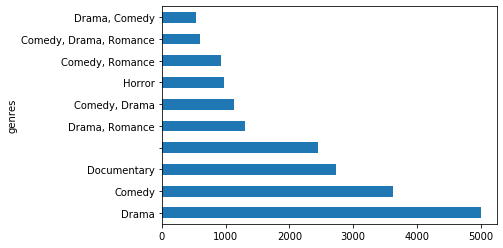

In [204]:
df.groupby(df['genres']).id.count().sort_values(ascending = False)[:10].plot(kind = 'barh')

Les films de genre *drame*, *comédie* et *documentaire* sont les plus représentés dans l'ensemble des films. Remarquons que les genres n'ont pas été récupérés indépendamment : on considère comme un genre à part entière des subsets composés de plusieurs genres. On pourrait vouloir voir la proportion des films contenant *Drama* ou *Romance* par exemple.

In [205]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
genre = pd.DataFrame(l, columns=['genre'])
genre = genre.genre.str.replace(r',', '')
genre

0        Animation
1           Comedy
2           Family
3        Adventure
4          Fantasy
           ...    
91104       Family
91105        Drama
91106       Action
91107        Drama
91108     Thriller
Name: genre, Length: 91109, dtype: object

Text(0.5, 1.0, 'Occurrences totales des genres')

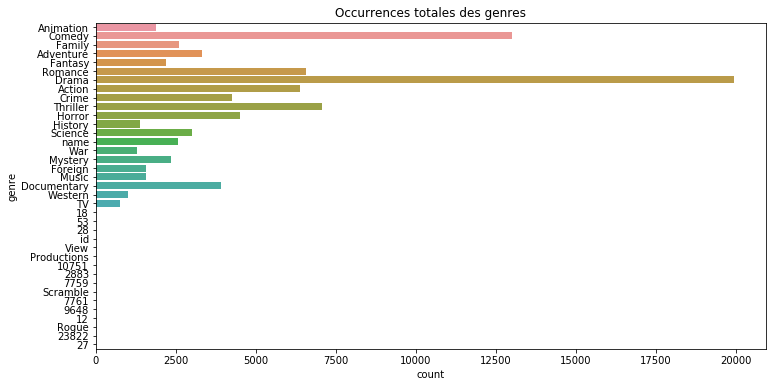

In [206]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = genre)
plt.title('Occurrences totales des genres')

Ces premières statistiques descriptives nous font apparaître que la base n'est pas bien nettoyée puiqu'il reste des id et des entrées qui ne correspondent pas au genre. 

In [207]:
df.genres[df.genres.notnull()].sort_values()

45465                                       
21814                                       
21818                                       
21836                                       
21853                                       
                        ...                 
22157                      Western, Thriller
36003                           Western, War
7989          Western, War, History, Romance
35587    id, Productions, Rogue, name, 23822
19730            id, View, name, Productions
Name: genres, Length: 45466, dtype: object

In [229]:
df.at[35587,'genres'] = ''
df.at[19730, 'genres'] = ''
df.genres = df.genres.str.replace('name','')
df.genres = df.genres.str.replace('Productions', '')
df.genres = df.genres.str.replace('18','')
df.genres = df.genres.str.replace('53','')
df.genres = df.genres.str.replace('28','')
df.genres = df.genres.str.replace('id','')
df.genres = df.genres.str.replace('View','')
df.genres = df.genres.str.replace('10751','')
df.genres = df.genres.str.replace('2883','')
df.genres = df.genres.str.replace('7759','')
df.genres = df.genres.str.replace('7761','')
df.genres = df.genres.str.replace('9648','')
df.genres = df.genres.str.replace('12','')
df.genres = df.genres.str.replace('23822','')
df.genres = df.genres.str.replace('27','')
df.genres = df.genres.str.replace('83','')
df.genres = df.genres.str.replace('Scramble','')

Une fois nettoyée : 


89391


Text(0.5, 1.0, 'Occurrences totales des genres')

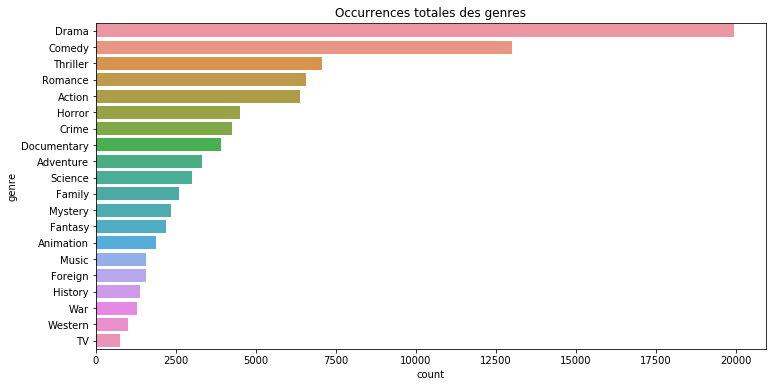

In [233]:
l = []
for i in trange(len(df)):
    genre = df.genres[i].split()
    for i in genre :
        l.append(i)
print(len(l))
df_genre = pd.DataFrame(l, columns=['genre'])
df_genre.genre = df_genre.genre.str.replace(r',', '')
df_genre.genre = df_genre[df_genre.genre != '']
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences totales des genres')


Ce nettoyage fait apparaître qu'il existe en fait des genres plus représentés que Documentaire mais qui figuraient souvent dans des regroupements (Thriller, Action, Horror ou Crime). 

Qu'en est-il de la complétude après nettoyage ? 

In [191]:
len(df.genres[df.genres == ''])
df.genres = df.genres.replace('', np.NaN)

Genres est complet à  94.62455461223772 %


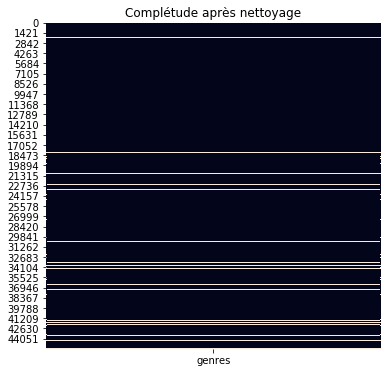

In [192]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df[['genres']].isnull(),cbar=False)
plt.title('Complétude après nettoyage')
print('Genres est complet à ',(1-len(df.genres[df.genres.isnull()])/len(df.genres))*100,'%')

## Nettoyage de la variable *budget*

In [236]:
df.budget.sort_values()

19730    /ff9qCepilowshEtG2GYWwzt2bs4.jpg
29503    /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
35587    /zaSf5OG7V8X8gqFvly88zDdRm46.jpg
45465                                   0
26992                                   0
                       ...               
39688                             9900000
34215                            99000000
11609                              994000
39203                              996519
9247                               998000
Name: budget, Length: 45466, dtype: object

Certaines cellules de cette colonne ne comportant pas d'information pertinente sur le budget du film, on va les considérer comme des NaN.

In [237]:
df.budget.loc[[19730,29503,35587]] = np.NaN

/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [238]:
df.budget = df.budget.astype(float)

# Scraping de mots-clés caractérisant le film

Le but de cette partie est de récupérer des mots-clés pour chaque film de la base. Pour un film donné, d'identifiant imbd_id, nous allons scraper la page https://www.imdb.com/title/imbd_id/keywords. Tout l'intérêt de la démarche est de pouvoir ensuite réaliser des nuages de mots, pour tenter de mettre en évidence les thématiques qui plaisent au public.

In [45]:
url_keywords = "https://www.imdb.com/title/" + df.imdb_id[1] +"/keywords"
    
request_text = request.urlopen(url_keywords).read()
page = bs4.BeautifulSoup(request_text, "lxml")

On peut ensuite récupérer facilement les mots-clés, repérés dans le code source par 'data-item-keyword' :

In [46]:
for post in page.findAll('td'):
    print(post.get('data-item-keyword'))

board game
adventurer
fight
game
year 1995
drumbeat
jumanji
franchise
first of series
first part
cult film
cult classic
christmas
1960s
1990s
20th century
jungle
magic
trapped in a game
dybbuk box
based on children's book
rainforest
surrealism
year 1969
new hampshire
blockbuster
wood
board
explorer
footwear
bug
danger
adulthood
child
childhood
perilous escape
pigtails
bearded man
shared universe
old photograph
child turning into animal
live action and animation
psychotronic film
supernatural power
1860s
19th century
friends who live together
overalls
actor playing multiple roles
animal killing
heavy rain
rampage
hiding in a closet
mutation
attic
friendship
fish out of water
stealing a car
hunter
year 1869
abandoned factory
tail
sporting goods store
small town
motorcycle
giant insect
forest
factory
exterminator
crocodile
big game hunter
one word title
no opening credits
rhinoceros
pelican
mosquito
monkey
lion
earthquake
zebra
elephant
bully
title spoken by character
woodland
lush
vegeta

On généralise la démarche à tous les films de la base, puis on stocke les mots-clés dans une nouvelle variable. Cependant, il a fallu exclure certains indices car nous avons constaté que pour ceux-ci, le lien https://www.imdb.com/title/imbd_id/keywords n'existait pas.

In [47]:
df_new_column = pd.DataFrame(0, index=np.arange(len(df)), columns=['keywords'])
df_2 = pd.concat([df.imdb_id, df.title, df_new_column], axis=1)

df_2

,imdb_id,title,keywords
0,tt0114709,Toy Story,0
1,tt0113497,Jumanji,0
2,tt0113228,Grumpier Old Men,0
3,tt0114885,Waiting to Exhale,0
4,tt0113041,Father of the Bride Part II,0
...,...,...,...
45461,tt6209470,Subdue,0
45462,tt2028550,Century of Birthing,0
45463,tt0303758,Betrayal,0
45464,tt0008536,Satan Triumphant,0


Code de scrapping des mots clefs. Malheureusement ce code étant très chronophage, on se contentera de charger les mots clefs déjà scrappés. 

In [48]:
for i in trange(len(df)):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l
    
df_2.to_csv('base_keywords.csv', sep = ';', encoding ='utf-8') 

/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

Voici ce que donne ce code sur les 10 premmières lignes de la base :

In [49]:
for i in trange(10):
  if df.imdb_id[i] == None or str(df.imdb_id[i]) == 'nan' or str(df.imdb_id[i]) == 'NaN' or str(df.imdb_id[i]) == '0' or i == 30399 or i == 30544 or i==33357:
    pass
  else:
    url_keywords = "https://www.imdb.com/title/" + df.imdb_id[i] +"/keywords"
    request_text = request.urlopen(url_keywords).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    l = []
    for post in page.findAll('td'):
      l.append(post.get('data-item-keyword'))
    df_2.keywords[i] = l


In [50]:
df_2.head(10)

,imdb_id,title,keywords
0,tt0114709,Toy Story,"[toy, rivalry, cowboy, cgi animation, claw cra..."
1,tt0113497,Jumanji,"[board game, adventurer, fight, game, year 199..."
2,tt0113228,Grumpier Old Men,"[boat, lake, neighbor, rivalry, minnesota, mar..."
3,tt0114885,Waiting to Exhale,"[black american, husband wife relationship, be..."
4,tt0113041,Father of the Bride Part II,"[fatherhood, doberman, dog, mansion, basketbal..."
5,tt0113277,Heat,"[gun battle, organized crime, honor, criminal ..."
6,tt0114319,Sabrina,"[character name as title, chauffeur, estate, p..."
7,tt0112302,Tom and Huck,"[rescue from drowning, near drowning, characte..."
8,tt0114576,Sudden Death,"[hockey, death in title, two word title, terro..."
9,tt0113189,GoldenEye,"[official james bond series, james bond charac..."


La procédure pour récupérer tous les mots-clés est très longue, c'est pourquoi nous ne l'avons lancée qu'une seule fois. Pour les prochains travaux sur les mots-clés, nous pourrons utiliser la base "base_keywords.csv", disponible sur le GitHub.

In [53]:
df_keywords = pd.read_csv(r'base_keywords.csv',sep = ';', encoding ='utf-8')

In [54]:
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45466 non-null  int64 
 1   imdb_id     45449 non-null  object
 2   title       45460 non-null  object
 3   keywords    45466 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


# Statistiques descriptives

## Genres

Text(0.5, 1.0, 'Occurrences des genres sur la base complète')

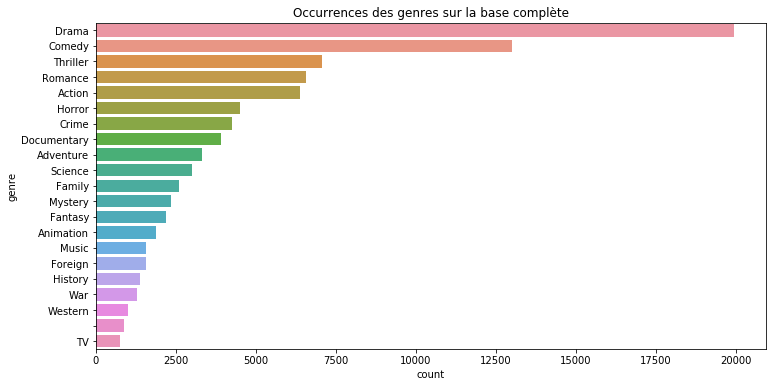

In [64]:
df_genre.genre = df_genre.genre.str.replace(r',', '')
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences des genres sur la base complète')

Le graphique ci-dessus, déjà présenté plus tôt, nous informe que les deux genres les plus représentés dans la base sont les comédies et les drames. Ce résultat est assez logique car ces types de films sont souvent donnés en complément d'un autre genre. A présent, étudions les films les mieux classés.

In [60]:
df.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45466, dtype: float64

En regardant de plus près la variable *vote_count*, nous constatons que certains films comportent moins de 10 évaluations. Par conséquent, afin d'avoir une analyse plus fine de la base, nous allons étudier les genres les plus représentés sur les films les mieux notés selon le classement imdb, sous contrainte que suffisamment de personnes les aient évalués (plus de 100).

On construit donc "best movies" correspondant aux films ayant été notés par plus de 100 personnes et ayant une note supérieure à 7.0 qu'on compare à l'ensemble des films ayant été notés par plus de 100 personnes. 

In [118]:
df.vote_average

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45466, dtype: float64

In [124]:
df_classement =df[df.vote_count>100].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 100 fois
df_best_movies = df_classement[df_classement.genres != '']    # on filtre sur les films pour lesquels le genre est renseigné
df_best_movies = df_best_movies[df.vote_average >= 7.0]      #on filtre sur les "meilleurs films" ie avec un score supérieur à 7
df_best_movies.reset_index(drop = True)
print('La base contient',len(df_best_movies),'films très bien notés (>= 7.0)')

La base contient 1760 films très bien notés (>= 7.0)


/Users/h2jw/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
l = []
for i in trange(len(df_best_movies)):
    if type(df_best_movies.genres.iloc[i]) == str :
        bm_genre = df_best_movies.genres.iloc[i].split()
        for i in bm_genre :
            l.append(i)
print(len(l))
df_bm_genre = pd.DataFrame(l, columns=['genre'])
df_bm_genre.genre = df_bm_genre.genre.str.replace(r',', '')
df_bm_genre['best_movies']=['Best movies' for i in range(len(df_bm_genre))]

df_genre['best_movies']=['All movies' for i in range(len(df_genre))]






4303


In [145]:
df_compare_genres = df_genre.append(df_bm_genre)

df_compare_genres.head()


,genre,best_movies
0,Documentary,All movies
1,Documentary,All movies
2,Comedy,All movies
3,Drama,All movies
4,Romance,All movies


Text(0.5, 1.0, 'Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

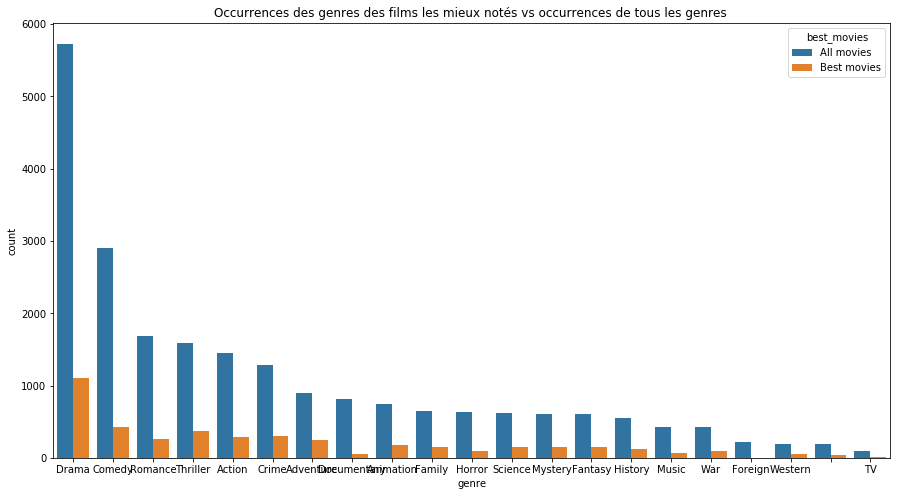

In [136]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='genre', hue='best_movies', data=df_compare_genres, order=df_genre.genre.value_counts(normalize=True).index)

plt.title('Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

Un plot des observations des genres des films les mieux notés contre ceux de tous les films ne nous permet pas de conclure. On normalise donc tout cela pour faire apparaître la fréquence d'apparition des genres pour l'ensemble des films et pour les films les mieux notés. 

Text(0.5, 1.0, 'Proportion des genres dans les films les mieux notés et dans tous les films')

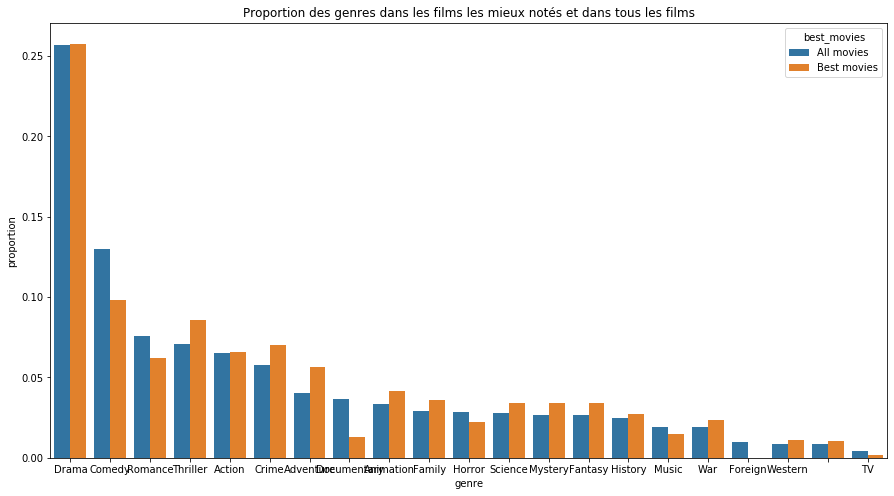

In [138]:
fig, ax = plt.subplots(figsize=(15,8))
x, y, hue = "genre", "proportion", "best_movies"
(df_compare_genres[x].groupby(df_compare_genres[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

plt.title('Proportion des genres dans les films les mieux notés et dans tous les films')


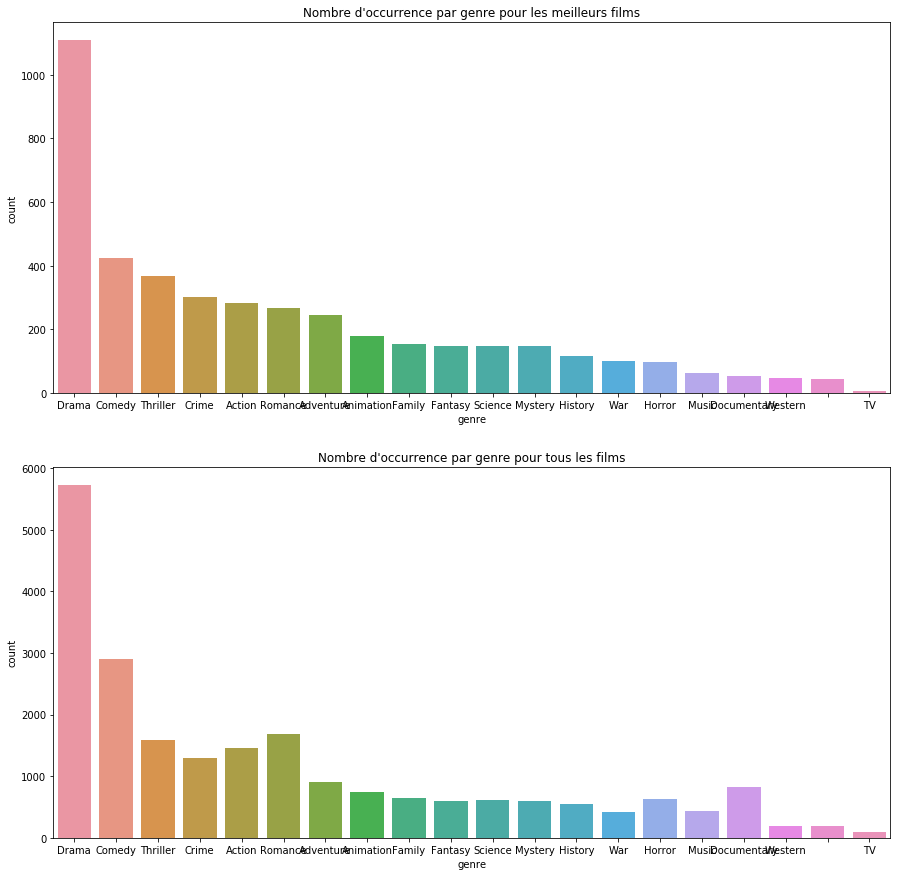

In [156]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(15,15))
sns.countplot(x = df_bm_genre.genre, order = df_bm_genre.genre.value_counts().index, ax = ax_1)
sns.countplot(x = df_genre.genre, order = df_bm_genre.genre.value_counts().index,ax=ax_2)
ax_1.title.set_text("Nombre d'occurrence par genre pour les meilleurs films")
ax_2.title.set_text("Nombre d'occurrence par genre pour tous les films")

Nous remarquons que la tendance est sensiblement la même. En effet, avec environ plus de 18 000 films dramatiques, il est assez normal de trouver un bon nombre de films bien notés dans cet ensemble.

Toutefois, on constate que bien que certains genres de films soient très présents dans la base, ils peuvent apparaître moins souvent dans le classement des meilleurs films. 

En effet, alors que le genre Romance était le 3ème genre le plus présent, ici nous remarquons qu'il apparaît beaucoup plus loin dans le classement des genres les plus représentés dans les films les mieux notés (6e position). A l'inverse, le genre Crime est le 4 ème genre le plus représenté dans l'échantillon, et gagne alors 2 places par rapport à son classement dans l'échantillon initial.

Ces observations nous amènent donc à tenter d'établir un score prenant à la fois en compte le score du vote et la popularité (peut-être reflétée par le nombre de vote) des films. 

## Variables quantitatives

### Budget

Une simple recherche internet nous informe que les budgets les plus petits dans la conception d'un film (appelés films "micro-budgets") s'élèvent à quelques milliers de dollars. On peut regarder la distribution des films micro-budgets.

In [ ]:
len(df.budget[df.budget == 0])/len(df.budget)*100

In [ ]:
df.budget[df.budget < 10000].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df.budget[df.budget < 10000].hist()
plt.title('Histogramme des films à budgets inférieurs à 10 000 dollars (microfilms)')

print('Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : ', (len(df.budget[df.budget < 1000])/len(df.budget[df.budget < 10000]))*100,'%')

Au sein des microfilms (budget inférieur à 10000 dollars), on compte 99.85% de films à budget inférieur à 1000 euros. Ce nombre est de fait assez suspect, on peut imaginer que la base contient des 0 pour les valeurs de budget inconnues ainsi que la plupart des nombres entre 0 et 1000 dollars de production sont des outliers dûs à des erreurs de saisies. 

In [ ]:
df_budget_ecrete = df.budget[df.budget > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_budget_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

In [ ]:
from scipy import stats
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
stats.probplot(df_budget_ecrete, plot=sns.mpl.pyplot)

L'information sur le budget paraît peu exploitable du fait de la dispersion des données... Par conséquent, nous allons nous intéresser plus en détails aux revenus générés par le film

### Revenus

## Statistiques sur les mots-clés

In [ ]:
with zipfile.ZipFile('base_keywords.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

In [ ]:
df_2 = pd.read_csv('base_keywords2.csv', sep=';', encoding = 'utf-8', nrows=45466, low_memory = False)
df_2

In [ ]:
df_2.keywords = df_2.keywords.str.replace(r'[^\w\s]+', '')

A l'aide du package *wordcloud*, nous allons pouvoir créer des nuages de mots.

In [ ]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = {'on', 'in', 'at', 'the', 'to', 'of', 'by'} # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

Nous allons tout d'abord stocker tous les mots-clés des films en une seule variable.

In [ ]:
mots_cles = ''
for i in trange(len(df_2)):
  mots_cles = mots_cles + str(df_2.keywords[i])

In [ ]:
mots_cles

Puis on affiche le nuage de mots correspondant à tous ces mots-clés.

In [ ]:
nuage_de_mots(mots_cles)

Le nuage de mots ci-dessus retranscrit le nombre d'apparitions des mots-clés dans la base entière. Pour obtenir plus de détails sur la fréquence d'apparition de ces mots-clés, intéressons-nous à ceux qui reviennnent au sein des meilleurs films par genre.

### Apparition des mots-clés en fonction du genre

In [ ]:
df.keywords = df_2.keywords

In [ ]:
liste_genre = list(df_genre.genre.unique())
liste_genre

In [ ]:
for movie_genre in tqdm(liste_genre):
  print(movie_genre)
  liste_movie_genre = ''
  if movie_genre != '':
    df_classement = df[df.vote_count>10].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 10 fois
    l = 0
    liste_movie_genre = ''
    for i in range(len(df)):
      while l < 100 :         # on s'intéresse aux 100 meilleurs films d'un genre
        if str() in str(df.genres[i].split()) == True:
          liste_movie_genre = liste_movie_genre + str(df_2.keywords[i])
          l += 1
    print(liste_movie_genre)
  nuage_de_mots(liste_movie_genre)

In [ ]:
str('Drama') in df.genres[2].split()

# Modélisation

Une première modélisation que l'on peut essayer d'implémenter est de prédire le score d'un film (vote_average) à l'aide des informations telles que le genre, les mots clefs, les acteurs, le producteur du film, et le budget. 

In [ ]:
y = 
feature_names = ['production_companies_name', '']